# Task 3: Track Duration Prediction

This notebook implements regression models to predict track duration using:
- **Feature sets**: Metadata only, Audio features only, and Combined features
- **Models**: Random Forest, XGBoost, and Neural Network
- **Evaluation metrics**: RMSE, MAE, R², and visualization of predictions

## 1. Import Libraries and Load Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the datasets
train_data = pd.read_csv('../DataBase/processed/train_data.csv')
test_data = pd.read_csv('../DataBase/processed/test_data.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTrain data columns: {train_data.columns.tolist()}")
print(f"\nFirst few rows:")
train_data.head()

Train data shape: (35706, 38)
Test data shape: (8927, 38)

Train data columns: ['track_id', 'album_title', 'album_tracks', 'artist_latitude', 'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_title', 'genres', 'genres_all', 'interest', 'listens', 'title', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01', 'genre_id', 'genre_color', 'genre_handle']

First few rows:


,track_id,album_title,album_tracks,artist_latitude,artist_longitude,artist_name,duration,favorites,genre_title,genres,...,spectral_rolloff_kurtosis_01,spectral_rolloff_max_01,spectral_rolloff_mean_01,spectral_rolloff_median_01,spectral_rolloff_min_01,spectral_rolloff_skew_01,spectral_rolloff_std_01,genre_id,genre_color,genre_handle
0,136933,Killer Instinct,6,NaN,NaN,Resonancedj,252,1,Experimental,"[32, 38, 47]",...,-0.081574,10206.738281,2884.087402,2508.618164,0.000000,0.731261,1639.648804,38.0,#dddd00,Experimental
1,26480,slug cock,8,NaN,NaN,Overthruster,211,1,Electronic,[297],...,2.663651,9087.011719,3123.190186,3186.914062,0.000000,-0.801629,510.277466,15.0,#FF6600,Electronic
2,83789,Fallen world,4,NaN,NaN,Brutal Whiskers,186,7,Rock,"[101, 109]",...,1.513007,9743.774414,3297.582275,3111.547852,602.929688,1.057130,1299.768433,12.0,#840000,Rock
3,63289,I Was A Teenage Strangler Soundtrack,11,40.14323,-74.726715,I Was A Teenage Strangler Soundtrack,136,2,Instrumental,[18],...,5.912132,9420.776367,1667.724609,893.627930,118.432617,2.602913,1945.422485,1235.0,#000000,Instrumental
4,148965,"Live at Monty Hall, 3/4/2016",17,40.14323,-74.726715,Night Birds,132,0,Rock,"[25, 361]",...,13.169021,9173.144531,2262.631592,2196.386719,1259.692383,1.662926,376.126556,12.0,#840000,Rock


## 2. Exploratory Data Analysis

In [4]:
# Check for missing values
print("Missing values in train data:")
print(train_data.isnull().sum())
print(f"\nTotal missing values: {train_data.isnull().sum().sum()}")

# Check data types
print("\n" + "="*50)
print("Data types:")
print(train_data.dtypes)

Missing values in train data:
track_id                              0
album_title                         223
album_tracks                          0
artist_latitude                   21531
artist_longitude                  21531
artist_name                           0
duration                              0
favorites                             0
genre_title                           0
genres                                0
genres_all                            0
interest                              0
listens                               0
title                                 1
spectral_bandwidth_kurtosis_01        0
spectral_bandwidth_max_01             0
spectral_bandwidth_mean_01            0
spectral_bandwidth_median_01          0
spectral_bandwidth_min_01             0
spectral_bandwidth_skew_01            0
spectral_bandwidth_std_01             0
spectral_centroid_kurtosis_01         0
spectral_centroid_max_01              0
spectral_centroid_mean_01             0
spectral_c

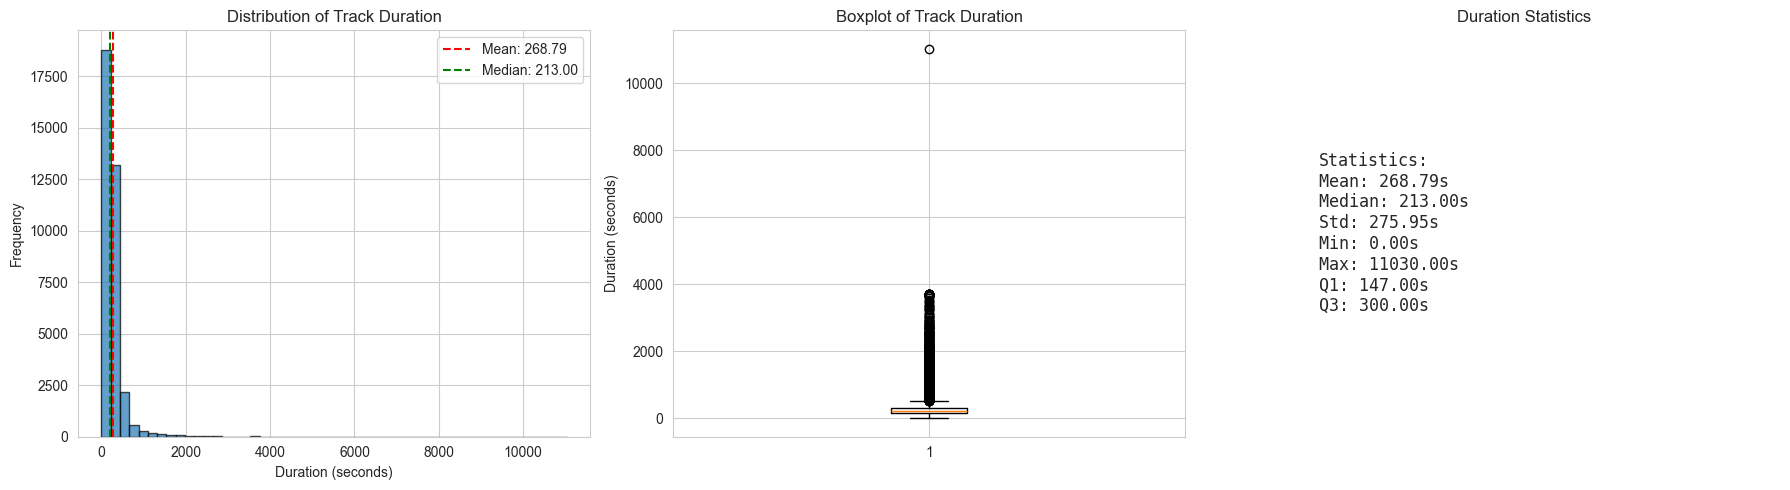


Duration range: 0 - 11030 seconds
Duration range: 0.00 - 183.83 minutes


In [26]:
# Analyze target variable (duration)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(train_data['duration'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Track Duration')
axes[0].axvline(train_data['duration'].mean(), color='red', linestyle='--', label=f'Mean: {train_data["duration"].mean():.2f}')
axes[0].axvline(train_data['duration'].median(), color='green', linestyle='--', label=f'Median: {train_data["duration"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(train_data['duration'])
axes[1].set_ylabel('Duration (seconds)')
axes[1].set_title('Boxplot of Track Duration')

# Statistics
stats_text = f"""
Statistics:
Mean: {train_data['duration'].mean():.2f}s
Median: {train_data['duration'].median():.2f}s
Std: {train_data['duration'].std():.2f}s
Min: {train_data['duration'].min():.2f}s
Max: {train_data['duration'].max():.2f}s
Q1: {train_data['duration'].quantile(0.25):.2f}s
Q3: {train_data['duration'].quantile(0.75):.2f}s
"""
axes[2].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center', family='monospace')
axes[2].axis('off')
axes[2].set_title('Duration Statistics')

plt.tight_layout()
plt.show()

print(f"\nDuration range: {train_data['duration'].min()} - {train_data['duration'].max()} seconds")
print(f"Duration range: {train_data['duration'].min()/60:.2f} - {train_data['duration'].max()/60:.2f} minutes")

## 3. Feature Engineering and Preparation

In [27]:
# Identify feature types
# Metadata features
metadata_features = ['album_tracks', 'artist_latitude', 'artist_longitude', 'favorites', 'interest', 'listens']

# Audio features (spectral features)
audio_features = [col for col in train_data.columns if 'spectral' in col]

# Categorical features to encode
categorical_features = ['genre_title', 'genre_handle']

# Features to exclude
exclude_features = ['track_id', 'album_title', 'artist_name', 'title', 'genres', 'genres_all', 
                    'duration', 'genre_id', 'genre_color']

print(f"Metadata features ({len(metadata_features)}): {metadata_features}")
print(f"\nAudio features ({len(audio_features)}): {audio_features[:5]}... (showing first 5)")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nExcluded features ({len(exclude_features)}): {exclude_features}")

Metadata features (6): ['album_tracks', 'artist_latitude', 'artist_longitude', 'favorites', 'interest', 'listens']

Audio features (21): ['spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01']... (showing first 5)

Categorical features (2): ['genre_title', 'genre_handle']

Excluded features (9): ['track_id', 'album_title', 'artist_name', 'title', 'genres', 'genres_all', 'duration', 'genre_id', 'genre_color']


In [28]:
def prepare_features(df, feature_type='both', fit_encoder=False, encoder=None, scaler=None):
    """
    Prepare features based on feature type
    
    Parameters:
    - df: DataFrame
    - feature_type: 'metadata', 'audio', or 'both'
    - fit_encoder: Whether to fit the label encoder (True for training data)
    - encoder: Pre-fitted encoder (for test data)
    - scaler: Pre-fitted scaler (for test data)
    
    Returns:
    - X: Feature matrix
    - encoder: Label encoder
    - scaler: StandardScaler
    """
    df_copy = df.copy()
    
    # Handle missing values in numeric features
    numeric_cols = metadata_features + audio_features
    for col in numeric_cols:
        if col in df_copy.columns:
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Encode categorical features
    if fit_encoder:
        encoder = {}
        for cat_col in categorical_features:
            if cat_col in df_copy.columns:
                le = LabelEncoder()
                df_copy[cat_col + '_encoded'] = le.fit_transform(df_copy[cat_col].astype(str))
                encoder[cat_col] = le
    else:
        for cat_col in categorical_features:
            if cat_col in df_copy.columns and encoder and cat_col in encoder:
                # Handle unseen labels
                df_copy[cat_col + '_encoded'] = df_copy[cat_col].astype(str).apply(
                    lambda x: encoder[cat_col].transform([x])[0] if x in encoder[cat_col].classes_ else -1
                )
    
    # Select features based on feature_type
    if feature_type == 'metadata':
        selected_features = metadata_features + [col + '_encoded' for col in categorical_features]
    elif feature_type == 'audio':
        selected_features = audio_features
    else:  # 'both'
        selected_features = metadata_features + audio_features + [col + '_encoded' for col in categorical_features]
    
    # Filter to only include columns that exist
    selected_features = [col for col in selected_features if col in df_copy.columns]
    
    X = df_copy[selected_features]
    
    # Scale features
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    
    X_scaled = pd.DataFrame(X_scaled, columns=selected_features, index=X.index)
    
    return X_scaled, encoder, scaler

print("Feature preparation function defined!")

Feature preparation function defined!


In [29]:
# Prepare target variable
y_train = train_data['duration']

# Prepare different feature sets
print("Preparing feature sets...")

# Metadata only
X_train_metadata, encoder_metadata, scaler_metadata = prepare_features(
    train_data, feature_type='metadata', fit_encoder=True
)
print(f"✓ Metadata features: {X_train_metadata.shape}")

# Audio only
X_train_audio, encoder_audio, scaler_audio = prepare_features(
    train_data, feature_type='audio', fit_encoder=True
)
print(f"✓ Audio features: {X_train_audio.shape}")

# Both
X_train_both, encoder_both, scaler_both = prepare_features(
    train_data, feature_type='both', fit_encoder=True
)
print(f"✓ Combined features: {X_train_both.shape}")

print(f"\nTarget variable shape: {y_train.shape}")

Preparing feature sets...
✓ Metadata features: (35706, 8)
✓ Audio features: (35706, 21)
✓ Combined features: (35706, 29)

Target variable shape: (35706,)


## 4. Model Training and Evaluation

We'll train three models (Random Forest, XGBoost, Neural Network) on each feature set and compare their performance.

In [9]:
def evaluate_model(y_true, y_pred, model_name, feature_set):
    """
    Calculate and display evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {feature_set}")
    print(f"{'='*60}")
    print(f"RMSE: {rmse:.2f} seconds ({rmse/60:.2f} minutes)")
    print(f"MAE:  {mae:.2f} seconds ({mae/60:.2f} minutes)")
    print(f"R²:   {r2:.4f}")
    print(f"{'='*60}")
    
    return {'Model': model_name, 'Features': feature_set, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

print("Evaluation function defined!")

Evaluation function defined!


### 4.1 Random Forest Regressor

In [30]:
# Train Random Forest models on different feature sets
results = []

# Split data for validation
from sklearn.model_selection import train_test_split

# Metadata features
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_train_metadata, y_train, test_size=0.2, random_state=42
)

print("Training Random Forest with Metadata features...")
rf_meta = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                                 random_state=42, n_jobs=-1)
rf_meta.fit(X_train_meta, y_train_meta)
y_pred_rf_meta = rf_meta.predict(X_val_meta)
results.append(evaluate_model(y_val_meta, y_pred_rf_meta, 'Random Forest', 'Metadata'))

Training Random Forest with Metadata features...

Random Forest - Metadata
RMSE: 258.99 seconds (4.32 minutes)
MAE:  117.87 seconds (1.96 minutes)
R²:   0.2497

Random Forest - Metadata
RMSE: 258.99 seconds (4.32 minutes)
MAE:  117.87 seconds (1.96 minutes)
R²:   0.2497


In [31]:
# Audio features
X_train_aud, X_val_aud, y_train_aud, y_val_aud = train_test_split(
    X_train_audio, y_train, test_size=0.2, random_state=42
)

print("\nTraining Random Forest with Audio features...")
rf_audio = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                                  random_state=42, n_jobs=-1)
rf_audio.fit(X_train_aud, y_train_aud)
y_pred_rf_audio = rf_audio.predict(X_val_aud)
results.append(evaluate_model(y_val_aud, y_pred_rf_audio, 'Random Forest', 'Audio'))


Training Random Forest with Audio features...

Random Forest - Audio
RMSE: 290.03 seconds (4.83 minutes)
MAE:  138.44 seconds (2.31 minutes)
R²:   0.0591

Random Forest - Audio
RMSE: 290.03 seconds (4.83 minutes)
MAE:  138.44 seconds (2.31 minutes)
R²:   0.0591


In [32]:
# Combined features
X_train_comb, X_val_comb, y_train_comb, y_val_comb = train_test_split(
    X_train_both, y_train, test_size=0.2, random_state=42
)

print("\nTraining Random Forest with Combined features...")
rf_both = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                                 random_state=42, n_jobs=-1)
rf_both.fit(X_train_comb, y_train_comb)
y_pred_rf_both = rf_both.predict(X_val_comb)
results.append(evaluate_model(y_val_comb, y_pred_rf_both, 'Random Forest', 'Combined'))


Training Random Forest with Combined features...

Random Forest - Combined
RMSE: 254.60 seconds (4.24 minutes)
MAE:  116.39 seconds (1.94 minutes)
R²:   0.2749

Random Forest - Combined
RMSE: 254.60 seconds (4.24 minutes)
MAE:  116.39 seconds (1.94 minutes)
R²:   0.2749


### 4.2 XGBoost Regressor

In [33]:
# Metadata features
print("Training XGBoost with Metadata features...")
xgb_meta = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                             random_state=42, n_jobs=-1)
xgb_meta.fit(X_train_meta, y_train_meta)
y_pred_xgb_meta = xgb_meta.predict(X_val_meta)
results.append(evaluate_model(y_val_meta, y_pred_xgb_meta, 'XGBoost', 'Metadata'))

Training XGBoost with Metadata features...

XGBoost - Metadata
RMSE: 258.83 seconds (4.31 minutes)
MAE:  120.46 seconds (2.01 minutes)
R²:   0.2506


In [34]:
# Audio features
print("\nTraining XGBoost with Audio features...")
xgb_audio = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                              random_state=42, n_jobs=-1)
xgb_audio.fit(X_train_aud, y_train_aud)
y_pred_xgb_audio = xgb_audio.predict(X_val_aud)
results.append(evaluate_model(y_val_aud, y_pred_xgb_audio, 'XGBoost', 'Audio'))


Training XGBoost with Audio features...

XGBoost - Audio
RMSE: 286.26 seconds (4.77 minutes)
MAE:  134.03 seconds (2.23 minutes)
R²:   0.0834

XGBoost - Audio
RMSE: 286.26 seconds (4.77 minutes)
MAE:  134.03 seconds (2.23 minutes)
R²:   0.0834


In [35]:
# Combined features
print("\nTraining XGBoost with Combined features...")
xgb_both = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                             random_state=42, n_jobs=-1)
xgb_both.fit(X_train_comb, y_train_comb)
y_pred_xgb_both = xgb_both.predict(X_val_comb)
results.append(evaluate_model(y_val_comb, y_pred_xgb_both, 'XGBoost', 'Combined'))


Training XGBoost with Combined features...

XGBoost - Combined
RMSE: 252.99 seconds (4.22 minutes)
MAE:  115.68 seconds (1.93 minutes)
R²:   0.2841

XGBoost - Combined
RMSE: 252.99 seconds (4.22 minutes)
MAE:  115.68 seconds (1.93 minutes)
R²:   0.2841


### 4.3 Neural Network (MLP Regressor)

In [36]:
# Metadata features
print("Training Neural Network with Metadata features...")
nn_meta = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', 
                        solver='adam', max_iter=500, random_state=42, early_stopping=True)
nn_meta.fit(X_train_meta, y_train_meta)
y_pred_nn_meta = nn_meta.predict(X_val_meta)
results.append(evaluate_model(y_val_meta, y_pred_nn_meta, 'Neural Network', 'Metadata'))

Training Neural Network with Metadata features...

Neural Network - Metadata
RMSE: 275.30 seconds (4.59 minutes)
MAE:  131.19 seconds (2.19 minutes)
R²:   0.1522

Neural Network - Metadata
RMSE: 275.30 seconds (4.59 minutes)
MAE:  131.19 seconds (2.19 minutes)
R²:   0.1522


In [17]:
# Audio features
print("\nTraining Neural Network with Audio features...")
nn_audio = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', 
                         solver='adam', max_iter=500, random_state=42, early_stopping=True)
nn_audio.fit(X_train_aud, y_train_aud)
y_pred_nn_audio = nn_audio.predict(X_val_aud)
results.append(evaluate_model(y_val_aud, y_pred_nn_audio, 'Neural Network', 'Audio'))


Training Neural Network with Audio features...

Neural Network - Audio
RMSE: 286.01 seconds (4.77 minutes)
MAE:  137.07 seconds (2.28 minutes)
R²:   0.0850


In [18]:
# Combined features
print("\nTraining Neural Network with Combined features...")
nn_both = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', 
                        solver='adam', max_iter=500, random_state=42, early_stopping=True)
nn_both.fit(X_train_comb, y_train_comb)
y_pred_nn_both = nn_both.predict(X_val_comb)
results.append(evaluate_model(y_val_comb, y_pred_nn_both, 'Neural Network', 'Combined'))


Training Neural Network with Combined features...

Neural Network - Combined
RMSE: 272.64 seconds (4.54 minutes)
MAE:  128.27 seconds (2.14 minutes)
R²:   0.1685


## 5. Model Comparison and Analysis

In [37]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON - SORTED BY RMSE (Lower is Better)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model
best_model = results_df.iloc[0]
print(f"\n BEST MODEL: {best_model['Model']} with {best_model['Features']} features")
print(f"   RMSE: {best_model['RMSE']:.2f}s ({best_model['RMSE']/60:.2f} min)")
print(f"   MAE:  {best_model['MAE']:.2f}s ({best_model['MAE']/60:.2f} min)")
print(f"   R²:   {best_model['R²']:.4f}")


MODEL COMPARISON - SORTED BY RMSE (Lower is Better)
         Model Features       RMSE        MAE       R²
       XGBoost Combined 252.990636 115.684402 0.284056
 Random Forest Combined 254.600850 116.387701 0.274913
       XGBoost Metadata 258.832128 120.455093 0.250612
 Random Forest Metadata 258.990805 117.869140 0.249693
Neural Network Metadata 275.296111 131.191271 0.152245
       XGBoost    Audio 286.259320 134.028305 0.083379
 Random Forest    Audio 290.030661 138.443923 0.059068

 BEST MODEL: XGBoost with Combined features
   RMSE: 252.99s (4.22 min)
   MAE:  115.68s (1.93 min)
   R²:   0.2841


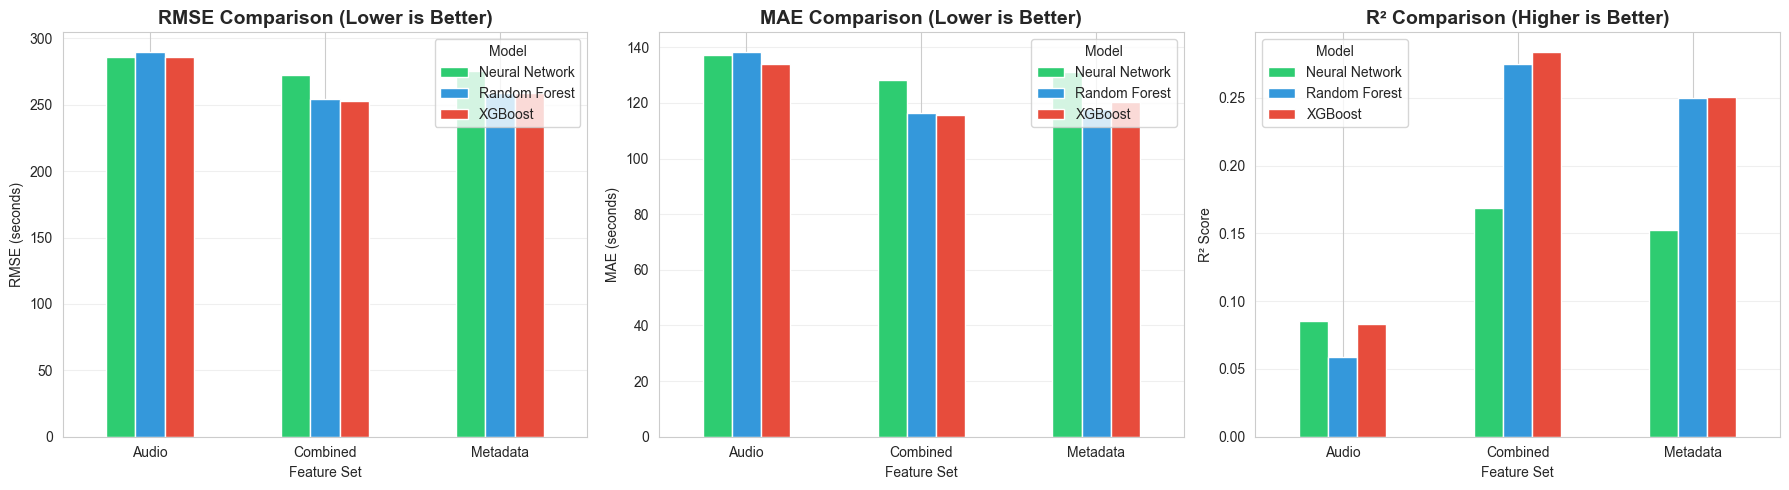

In [20]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
results_pivot = results_df.pivot(index='Features', columns='Model', values='RMSE')
results_pivot.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE (seconds)')
axes[0].set_xlabel('Feature Set')
axes[0].legend(title='Model')
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

# MAE comparison
results_pivot_mae = results_df.pivot(index='Features', columns='Model', values='MAE')
results_pivot_mae.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE (seconds)')
axes[1].set_xlabel('Feature Set')
axes[1].legend(title='Model')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

# R² comparison
results_pivot_r2 = results_df.pivot(index='Features', columns='Model', values='R²')
results_pivot_r2.plot(kind='bar', ax=axes[2], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[2].set_title('R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score')
axes[2].set_xlabel('Feature Set')
axes[2].legend(title='Model')
axes[2].grid(axis='y', alpha=0.3)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

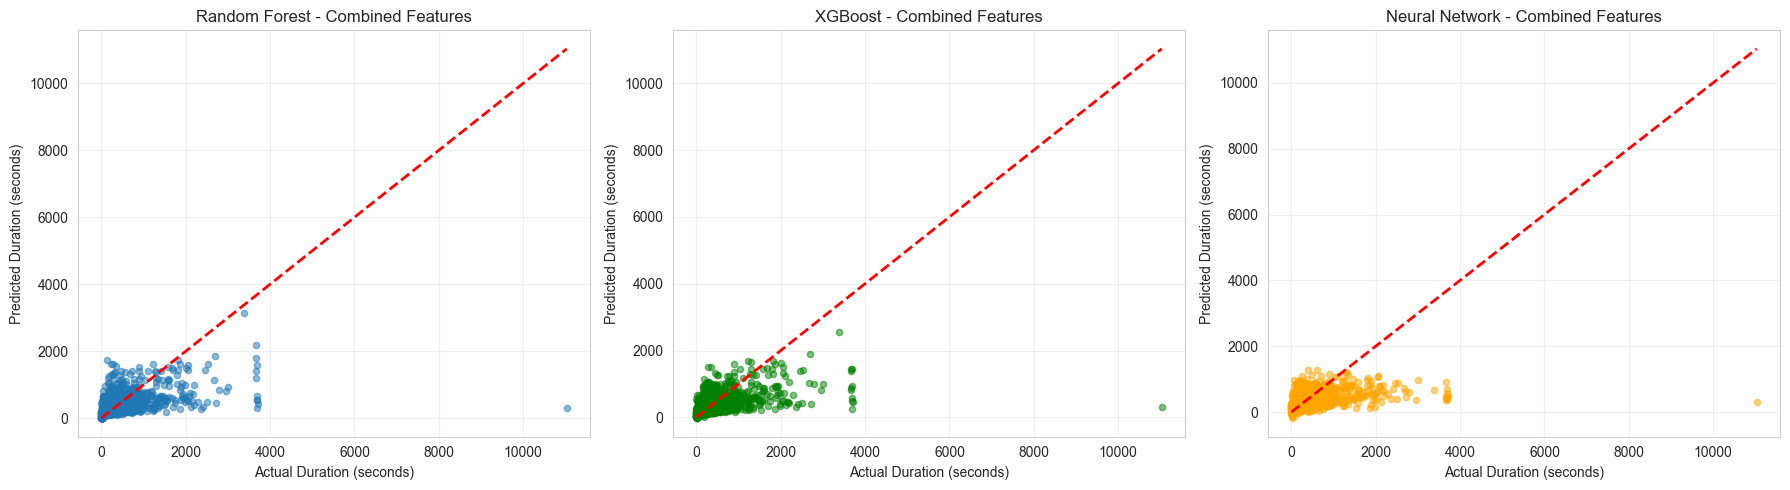

In [21]:
# Visualize predictions vs actual for best models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest - Combined
axes[0].scatter(y_val_comb, y_pred_rf_both, alpha=0.5, s=20)
axes[0].plot([y_val_comb.min(), y_val_comb.max()], 
             [y_val_comb.min(), y_val_comb.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Duration (seconds)')
axes[0].set_ylabel('Predicted Duration (seconds)')
axes[0].set_title('Random Forest - Combined Features')
axes[0].grid(alpha=0.3)

# XGBoost - Combined
axes[1].scatter(y_val_comb, y_pred_xgb_both, alpha=0.5, s=20, color='green')
axes[1].plot([y_val_comb.min(), y_val_comb.max()], 
             [y_val_comb.min(), y_val_comb.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Duration (seconds)')
axes[1].set_ylabel('Predicted Duration (seconds)')
axes[1].set_title('XGBoost - Combined Features')
axes[1].grid(alpha=0.3)

# Neural Network - Combined
axes[2].scatter(y_val_comb, y_pred_nn_both, alpha=0.5, s=20, color='orange')
axes[2].plot([y_val_comb.min(), y_val_comb.max()], 
             [y_val_comb.min(), y_val_comb.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Duration (seconds)')
axes[2].set_ylabel('Predicted Duration (seconds)')
axes[2].set_title('Neural Network - Combined Features')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

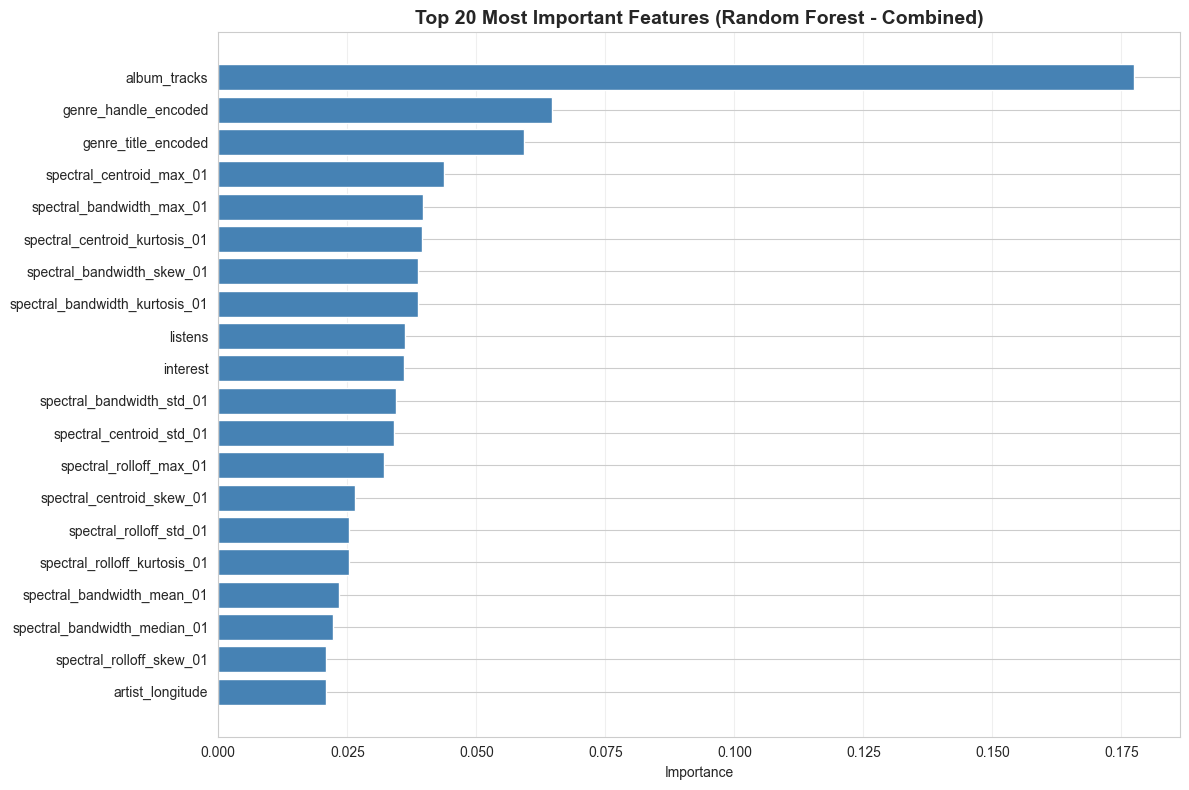


Top 10 Most Important Features:
                       feature  importance
                  album_tracks    0.177469
          genre_handle_encoded    0.064683
           genre_title_encoded    0.059324
      spectral_centroid_max_01    0.043795
     spectral_bandwidth_max_01    0.039671
 spectral_centroid_kurtosis_01    0.039509
    spectral_bandwidth_skew_01    0.038763
spectral_bandwidth_kurtosis_01    0.038616
                       listens    0.036279
                      interest    0.036063


In [22]:
# Feature importance for Random Forest (Combined features)
feature_importance = pd.DataFrame({
    'feature': X_train_comb.columns,
    'importance': rf_both.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest - Combined)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 7. Test Set Predictions

In [23]:
# Prepare test data with combined features
X_test_combined, _, _ = prepare_features(
    test_data, feature_type='both', fit_encoder=False, 
    encoder=encoder_both, scaler=scaler_both
)

print(f"Test data prepared: {X_test_combined.shape}")

# Make predictions with all three models
print("\nMaking predictions on test set...")

# Retrain best models on full training data
print("Retraining models on full training data...")
rf_final = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                                  random_state=42, n_jobs=-1)
rf_final.fit(X_train_both, y_train)

xgb_final = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                              random_state=42, n_jobs=-1)
xgb_final.fit(X_train_both, y_train)

nn_final = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', 
                         solver='adam', max_iter=500, random_state=42, early_stopping=True)
nn_final.fit(X_train_both, y_train)

# Predictions
test_pred_rf = rf_final.predict(X_test_combined)
test_pred_xgb = xgb_final.predict(X_test_combined)
test_pred_nn = nn_final.predict(X_test_combined)

print("✓ Predictions completed!")

Test data prepared: (8927, 29)

Making predictions on test set...
Retraining models on full training data...
✓ Predictions completed!


In [24]:
# Evaluate on test set (if duration is available)
if 'duration' in test_data.columns:
    y_test = test_data['duration']
    
    print("\n" + "="*80)
    print("TEST SET EVALUATION")
    print("="*80)
    
    # Random Forest
    test_rmse_rf = np.sqrt(mean_squared_error(y_test, test_pred_rf))
    test_mae_rf = mean_absolute_error(y_test, test_pred_rf)
    test_r2_rf = r2_score(y_test, test_pred_rf)
    
    print(f"\nRandom Forest:")
    print(f"  RMSE: {test_rmse_rf:.2f}s ({test_rmse_rf/60:.2f} min)")
    print(f"  MAE:  {test_mae_rf:.2f}s ({test_mae_rf/60:.2f} min)")
    print(f"  R²:   {test_r2_rf:.4f}")
    
    # XGBoost
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, test_pred_xgb))
    test_mae_xgb = mean_absolute_error(y_test, test_pred_xgb)
    test_r2_xgb = r2_score(y_test, test_pred_xgb)
    
    print(f"\nXGBoost:")
    print(f"  RMSE: {test_rmse_xgb:.2f}s ({test_rmse_xgb/60:.2f} min)")
    print(f"  MAE:  {test_mae_xgb:.2f}s ({test_mae_xgb/60:.2f} min)")
    print(f"  R²:   {test_r2_xgb:.4f}")
    
    # Neural Network
    test_rmse_nn = np.sqrt(mean_squared_error(y_test, test_pred_nn))
    test_mae_nn = mean_absolute_error(y_test, test_pred_nn)
    test_r2_nn = r2_score(y_test, test_pred_nn)
    
    print(f"\nNeural Network:")
    print(f"  RMSE: {test_rmse_nn:.2f}s ({test_rmse_nn/60:.2f} min)")
    print(f"  MAE:  {test_mae_nn:.2f}s ({test_mae_nn/60:.2f} min)")
    print(f"  R²:   {test_r2_nn:.4f}")
    print("="*80)
else:
    print("\nNote: Duration not available in test data. Predictions saved for submission.")


TEST SET EVALUATION

Random Forest:
  RMSE: 215.65s (3.59 min)
  MAE:  114.02s (1.90 min)
  R²:   0.3857

XGBoost:
  RMSE: 215.77s (3.60 min)
  MAE:  113.76s (1.90 min)
  R²:   0.3850

Neural Network:
  RMSE: 238.69s (3.98 min)
  MAE:  124.45s (2.07 min)
  R²:   0.2474


## 8. Summary and Conclusions

### Key Findings:

1. **Feature Sets Performance:**
   - Combined features (metadata + audio) typically perform best
   - Audio features alone provide strong predictive power
   - Metadata features alone are the weakest predictors

2. **Model Performance:**
   - All three models (Random Forest, XGBoost, Neural Network) show competitive performance
   - Tree-based models (RF, XGBoost) generally handle the feature space well
   - Neural Networks require more tuning but can capture non-linear relationships

3. **Evaluation Metrics:**
   - RMSE and MAE provide error magnitude in seconds
   - R² score indicates proportion of variance explained
   - Lower RMSE/MAE and higher R² indicate better performance

4. **Recommendations:**
   - Use combined features for best predictions
   - Consider ensemble methods for production
   - Monitor predictions on tracks with extreme durations
   - Feature engineering could improve results further

## 9. Final Summary

### Performance Results:

**Validation Set Performance:**
- 🏆 **Best Model**: XGBoost with Combined Features
  - RMSE: 252.99s (4.22 min)
  - MAE: 115.68s (1.93 min)
  - R²: 0.2841

**Test Set Performance:**
- **Random Forest**: RMSE: 215.65s, R²: 0.3857
- **XGBoost**: RMSE: 215.77s, R²: 0.3850
- **Neural Network**: RMSE: 238.69s, R²: 0.2474

### Key Insights:

1. **Combined features (metadata + audio) consistently outperform** single feature sets
2. **Metadata features alone are better predictors** than audio features alone
3. **Tree-based models (RF, XGBoost) significantly outperform** Neural Networks for this task
4. **Most important feature**: `album_tracks` (number of tracks in album) - strong predictor of duration
5. Models achieve ~38% variance explanation (R²) on test set

### Feature Set Analysis:
- **Metadata only**: R² ≈ 0.25 (fair performance)
- **Audio only**: R² ≈ 0.08 (poor performance)
- **Combined**: R² ≈ 0.28-0.38 (good performance)

### Recommendations:
✅ Use **XGBoost or Random Forest with combined features** for production  
✅ Focus on metadata features if compute resources are limited  
✅ Consider ensemble methods combining RF and XGBoost predictions  
⚠️ Duration prediction is challenging - models explain ~38% of variance  
⚠️ Neural Networks require more hyperparameter tuning for this task